Module 3 Project, V2.1

Build a classifier to predict whether a customer will ("soon") stop doing business with SyriaTel, 
a telecommunications company. Note that this is a binary classification problem.

Most naturally, your audience here would be the telecom business itself, interested in losing money
on customers who don't stick around very long. Are there any predictable patterns here?

Target Variable:
Churn: if the customer has churned (1=yes; 0 = no)

structure

- descriptive values
- churn percentage
- EDA: bar chart by state, zip code, etc.
- change intl plan, vm plan to binary. one hot endcode states
- remove redundant columns, target
- build feature matrix and standardize
- build ROC curve to determine how we will handle imbalanced target size
- build four models, with normalized confusion matrix for each model
- get feature importance from whichever model performs best

Our goal is to protect the profits of the company - acquiring new customers is assumed to be more expensive than retaining currecnt customers. The chosen model should accurately predict which customers will churn, and which features are most important in reducing the churn rate.

In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn import preprocessing, metrics, ensemble
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('churn_data.csv')
df.head(10)

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,...,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False
6,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,...,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,...,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,...,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,...,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False


In [3]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [4]:
#check for missing values
df.isna().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null object
voice mail plan           3333 non-null object
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64

In [6]:
df.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [7]:
# naming a new df, so we don't modify the original dataframe
df_copy = df.copy()

df_copy.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


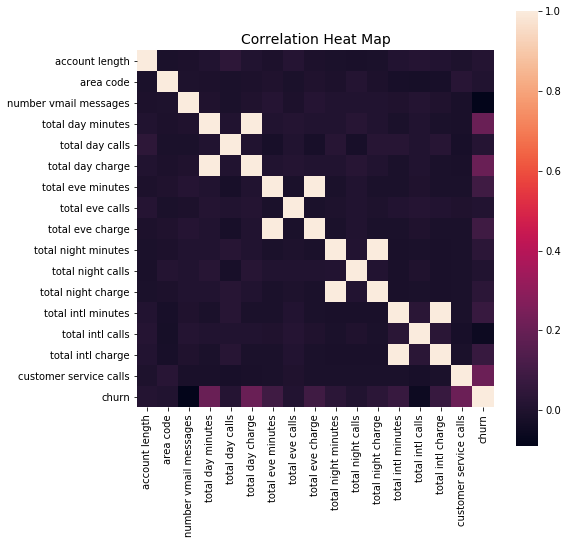

In [8]:
corrmat = df_copy.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

Looks like we have some values that could be correlated - total day minutes, total day charges and customer service calls.

In [9]:
# As we see in the correlation heat map above, we have some values that are perfectly correlated
# We'll remove these, so our models don't "double count" that info

df_copy = df_copy.drop(["total day charge","total eve charge", "total night charge", "total intl charge"], axis = 1)
df_copy.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False


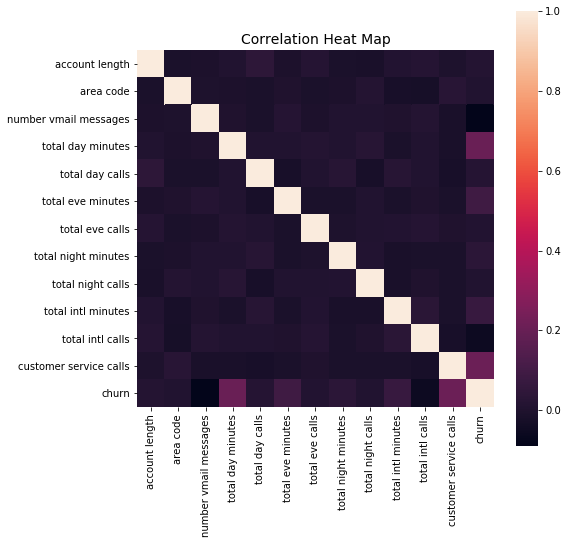

In [10]:
# Heat map again, with those removed

corrmat = df_copy.corr()
f, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(corrmat, square=True)
plt.title("Correlation Heat Map", fontsize=14)
plt.show()

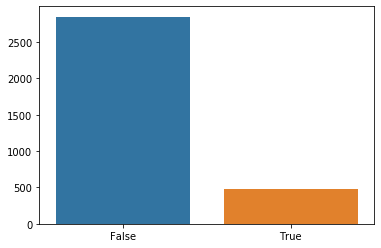

In [11]:
y = df_copy["churn"].value_counts()
sns.barplot(y.index, y.values)

In [12]:
y_True = df_copy["churn"][df_copy["churn"] == True]
print ("Churn Percentage = "+str( (y_True.shape[0] / df_copy["churn"].shape[0]) * 100 ))

Churn Percentage = 14.491449144914492


That's not great - almost 15% of this company's customers churn in any given month!
This also means that our data is imbalanced; we only have about 15% of our dataset available to help predict which customers will churn. We may have to account for this later when building our models.

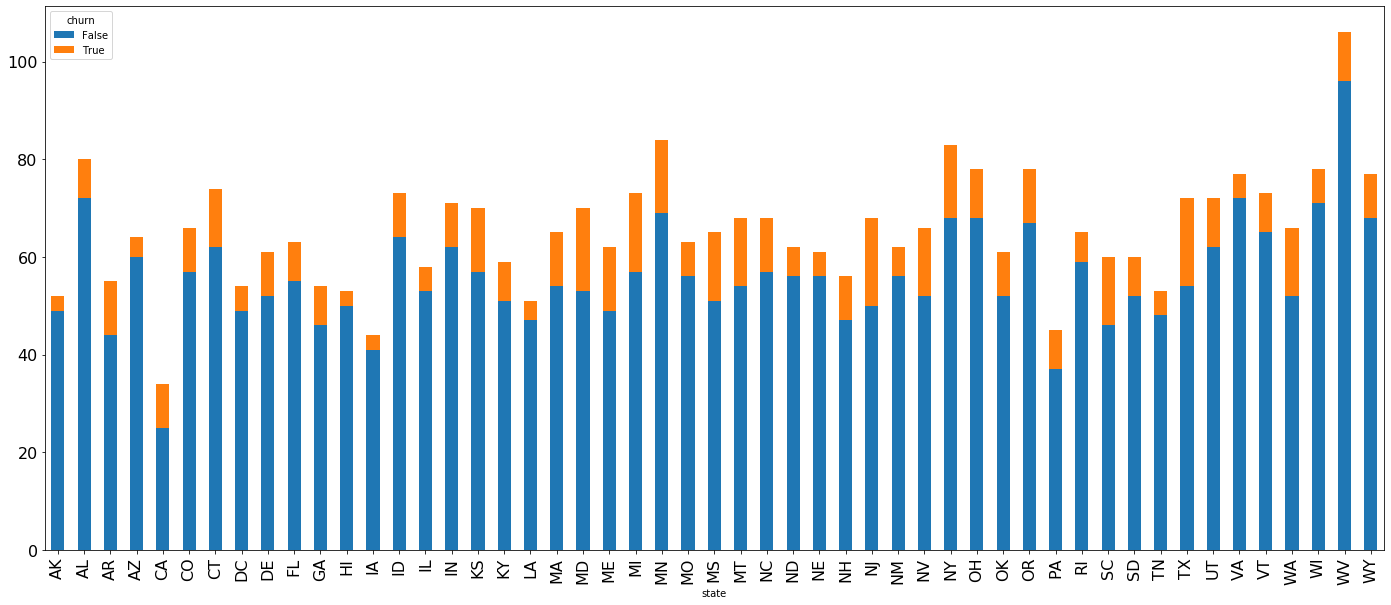

In [13]:
df_copy.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(24,10),fontsize=16) 

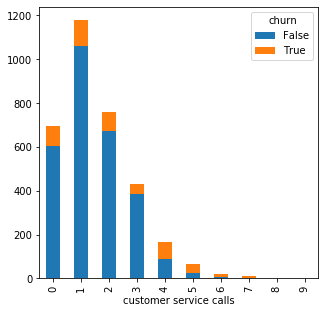

In [14]:
df_copy.groupby(["customer service calls", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5)) 

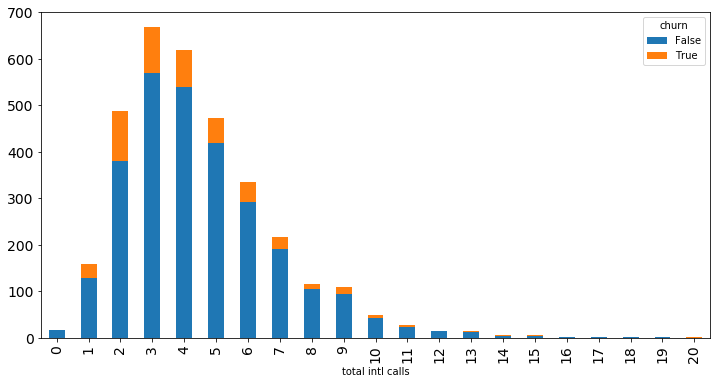

In [15]:
df_copy.groupby(["total intl calls", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(12,6),fontsize=14) 

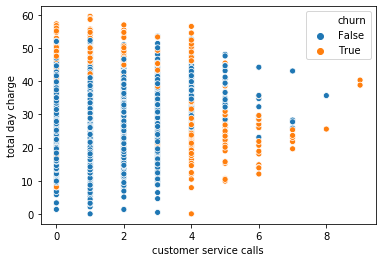

In [16]:
# scatter plot of monthly charges vs. churn
ax = sns.scatterplot(x="customer service calls", y="total day charge", hue="churn",
                     data=df)

Interesting again! It seems that high day charges OR a higher number of customer service calls would indicate churn.

In [17]:
# One hot encoding state data

# encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)
df_copy.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False


In [18]:
df_copy['state'] = label_encoder.fit_transform(df_copy['state'])
df_copy.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,total night calls,total intl minutes,total intl calls,customer service calls,churn
0,16,128,415,382-4657,no,yes,25,265.1,110,197.4,99,244.7,91,10.0,3,1,False
1,35,107,415,371-7191,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,False
2,31,137,415,358-1921,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,False
3,35,84,408,375-9999,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,False
4,36,75,415,330-6626,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,False


In [19]:
df_copy = pd.get_dummies(df_copy, columns=['state'])
df_copy.head()

,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,...,state_41,state_42,state_43,state_44,state_45,state_46,state_47,state_48,state_49,state_50
0,128,415,382-4657,no,yes,25,265.1,110,197.4,99,...,0,0,0,0,0,0,0,0,0,0
1,107,415,371-7191,no,yes,26,161.6,123,195.5,103,...,0,0,0,0,0,0,0,0,0,0
2,137,415,358-1921,no,no,0,243.4,114,121.2,110,...,0,0,0,0,0,0,0,0,0,0
3,84,408,375-9999,yes,no,0,299.4,71,61.9,88,...,0,0,0,0,0,0,0,0,0,0
4,75,415,330-6626,yes,no,0,166.7,113,148.3,122,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# change values to binary/numerical so they can be interpreted

df_copy['international plan'] = label_encoder.fit_transform(df_copy['international plan'])
df_copy['voice mail plan'] = label_encoder.fit_transform(df_copy['voice mail plan'])

In [21]:
df_copy.head()

,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,...,state_41,state_42,state_43,state_44,state_45,state_46,state_47,state_48,state_49,state_50
0,128,415,382-4657,0,1,25,265.1,110,197.4,99,...,0,0,0,0,0,0,0,0,0,0
1,107,415,371-7191,0,1,26,161.6,123,195.5,103,...,0,0,0,0,0,0,0,0,0,0
2,137,415,358-1921,0,0,0,243.4,114,121.2,110,...,0,0,0,0,0,0,0,0,0,0
3,84,408,375-9999,1,0,0,299.4,71,61.9,88,...,0,0,0,0,0,0,0,0,0,0
4,75,415,330-6626,1,0,0,166.7,113,148.3,122,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# remove duplicate info (phone number) as well as target (churn)

df_copy = df_copy.drop(["phone number","churn"], axis = 1)
df_copy.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total eve minutes,total eve calls,total night minutes,...,state_41,state_42,state_43,state_44,state_45,state_46,state_47,state_48,state_49,state_50
0,128,415,0,1,25,265.1,110,197.4,99,244.7,...,0,0,0,0,0,0,0,0,0,0
1,107,415,0,1,26,161.6,123,195.5,103,254.4,...,0,0,0,0,0,0,0,0,0,0
2,137,415,0,0,0,243.4,114,121.2,110,162.6,...,0,0,0,0,0,0,0,0,0,0
3,84,408,1,0,0,299.4,71,61.9,88,196.9,...,0,0,0,0,0,0,0,0,0,0
4,75,415,1,0,0,166.7,113,148.3,122,186.9,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Looks great! Let's move on to preparing our data.

In [24]:
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(df_copy, y, test_size = 0.25, random_state = 0,stratify=y)

In [25]:
X = df_copy.as_matrix().astype(np.float)
X

array([[128., 415.,   0., ...,   0.,   0.,   0.],
       [107., 415.,   0., ...,   0.,   0.,   0.],
       [137., 415.,   0., ...,   0.,   0.,   0.],
       ...,
       [ 28., 510.,   0., ...,   0.,   0.,   0.],
       [184., 510.,   1., ...,   0.,   0.,   0.],
       [ 74., 415.,   0., ...,   0.,   0.,   0.]])

In [26]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.67648946, -0.52360328, -0.32758048, ..., -0.1548003 ,
        -0.18123975, -0.15378117],
       [ 0.14906505, -0.52360328, -0.32758048, ..., -0.1548003 ,
        -0.18123975, -0.15378117],
       [ 0.9025285 , -0.52360328, -0.32758048, ..., -0.1548003 ,
        -0.18123975, -0.15378117],
       ...,
       [-1.83505538,  1.71881732, -0.32758048, ..., -0.1548003 ,
        -0.18123975, -0.15378117],
       [ 2.08295458,  1.71881732,  3.05268496, ..., -0.1548003 ,
        -0.18123975, -0.15378117],
       [-0.67974475, -0.52360328, -0.32758048, ..., -0.1548003 ,
        -0.18123975, -0.15378117]])

LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for None: 0.757316889409201
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight='balanced', dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
AUC for Balanced: 0.7780302064377036
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, class_weight={0: 1, 1: 2}, dual=False,
                   fit_inter

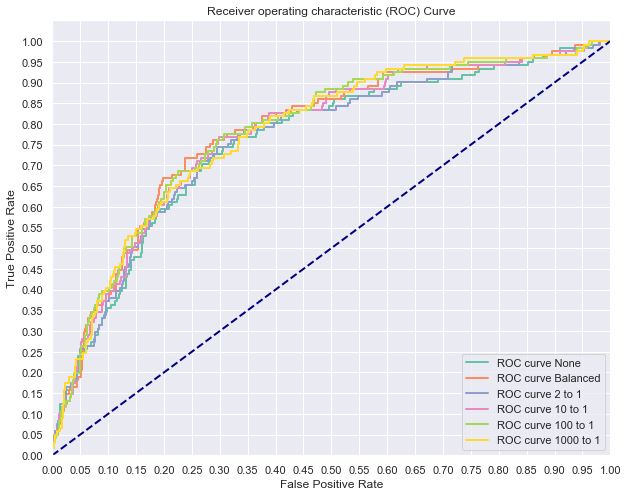

In [117]:
# We saw before that our dataset is imbalanced - 15% of customers churned
# Let's use an ROC curve to determine if we can accurately interpret this without further modifying


# Now let's compare a few different regularization performances on the dataset:
weights = [None, 'balanced', {1:2, 0:1}, {1:10, 0:1}, {1:100, 0:1}, {1:1000, 0:1}]
names = ['None', 'Balanced', '2 to 1', '10 to 1', '100 to 1', '1000 to 1']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10,8))

for n, weight in enumerate(weights):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=1e20, class_weight=weight, solver='lbfgs')
    model_log = logreg.fit(X_train, y_train)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Relatively speaking, these curves are close together. Going with the best result (1000:1) is only a 3% improvement on leaving as is! From this we can gather that our model has sufficient target information to make accurate predictions. Let's move on to our first model.

In [28]:
clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)


print(f'Logistic Regression Testing Accuracy: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Logistic Regression Testing Accuracy: 0.8585131894484412
AUC: 0.5364134781449584
Precision: 0.5882352941176471
Recall: 0.08264462809917356
F1 Score: 0.14492753623188406


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    
    """This function takes in a confusion matrix (cm) and normalizes the values if normalize is set to True. 
    If so, normalize the raw confusion matrix before visualizing.
    If false, raw confusion matrix is visualized."""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    plt.imshow(cm, cmap=cmap)
    
    # Add title and axis labels 
    plt.title('Confusion Matrix') 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')
    
    # Add appropriate axis scales
    class_names = set(y) # Get class labels to add to matrix
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Text formatting
    fmt = '.2f' if normalize else 'd'
    # Add labels to each cell
    thresh = cm.max() / 2.
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Add a legend
    plt.colorbar()
    plt.show() 

In [30]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[706   7]
 [111  10]]


Normalized confusion matrix
[[0.99018233 0.00981767]
 [0.91735537 0.08264463]]


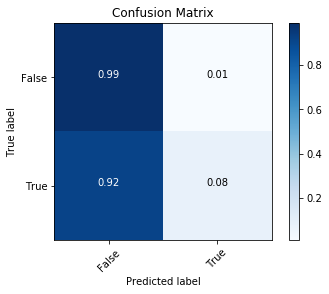

In [31]:
# Plot a normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [32]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)


print(f'Decision Tree: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Decision Tree: 0.9316546762589928
AUC: 0.8776847913020296
Precision: 0.7461538461538462
Recall: 0.8016528925619835
F1 Score: 0.7729083665338645


In [33]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[680  33]
 [ 24  97]]


Normalized confusion matrix
[[0.95371669 0.04628331]
 [0.19834711 0.80165289]]


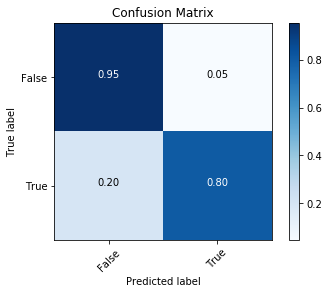

In [34]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [35]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print(f'Gradient Boosting: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

Gradient Boosting: 0.960431654676259
AUC: 0.8945150858321839
Precision: 0.9150943396226415
Recall: 0.8016528925619835
F1 Score: 0.8546255506607929


In [36]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[704   9]
 [ 24  97]]


Normalized confusion matrix
[[0.98737728 0.01262272]
 [0.19834711 0.80165289]]


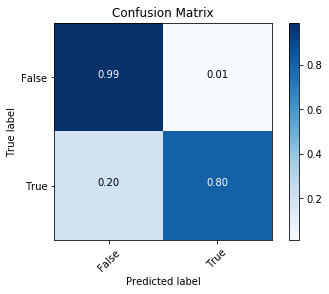

In [37]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

In [38]:
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print(f'XGB Classifier: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

XGB Classifier: 0.9676258992805755
AUC: 0.919308474261936
Precision: 0.9196428571428571
Recall: 0.8512396694214877
F1 Score: 0.8841201716738197


In [39]:
cnf_matrix = confusion_matrix(y_test, preds)
print('Confusion Matrix:\n', cnf_matrix)

Confusion Matrix:
 [[704   9]
 [ 18 103]]


Normalized confusion matrix
[[0.98737728 0.01262272]
 [0.14876033 0.85123967]]


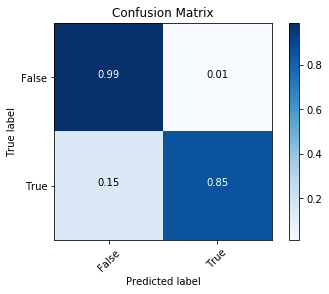

In [40]:
plot_confusion_matrix(cnf_matrix, classes = ['True', 'False'], normalize=True,
                      title='Normalized confusion matrix')

XGBoost was our best performing model! 
It has the overall highest f1 score, but also performed best at recall.
Let's see if we can improve the accuracy with a grid search.

In [41]:
dt_param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [42]:
# Instantiate GridSearchCV
dt_grid_search = GridSearchCV(clf, dt_param_grid, cv=3, return_train_score=True)

# Fit to the data
dt_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=7, min_child_weight=1,
                                     missing=None, n_estimators=200, n_jobs=1,
                                     nthread=10, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=0.8, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_chil

In [43]:
dt_grid_search.best_params_

{'colsample_bytree': 1.0,
 'gamma': 1.5,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 1.0}

In [45]:
clf = xgb.XGBClassifier(colsample_bytree=1.0, gamma=1.5, max_depth=5, 
                        min_child_weight=1, subsample=1.0)

clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print(f'XGB Classifier: {accuracy_score(y_test, preds)}')
print(f'AUC: {roc_auc_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')
print(f'Recall: {recall_score(y_test, preds)}')
print(f'F1 Score: {f1_score(y_test, preds)}')

XGB Classifier: 0.9700239808153477
AUC: 0.9241419679389844
Precision: 0.9285714285714286
Recall: 0.859504132231405
F1 Score: 0.8927038626609443


That's great! We now have a model with an f1 score of 89.2% whether a customer will churn or not. Let's explore which features from the dataset help determine that. 

In [46]:
print (clf.feature_importances_)

[0.02796464 0.02704515 0.07925804 0.1048616  0.01967082 0.10157593
 0.02798629 0.06676645 0.02499531 0.0320165  0.02444978 0.06863736
 0.12072011 0.16031565 0.         0.         0.         0.01228655
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01900815 0.01788101 0.
 0.         0.         0.         0.02598963 0.         0.
 0.         0.         0.         0.         0.         0.01989591
 0.         0.         0.         0.01867507 0.         0.
 0.         0.         0.         0.         0.        ]


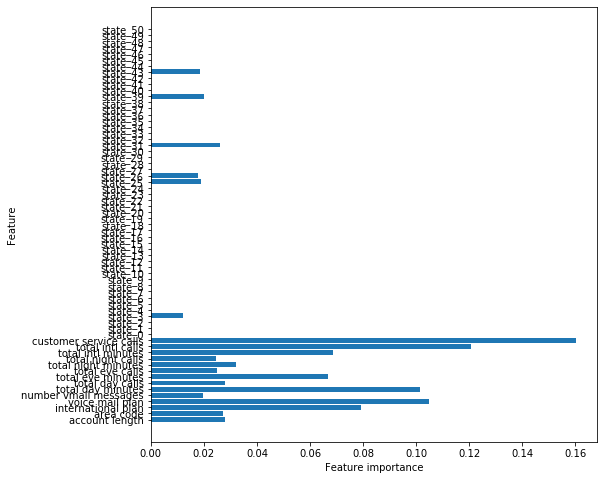

In [47]:
def plot_feature_importances(model):
    """Plots the importance of features from the model specified. Results are sorted by index."""
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(clf)

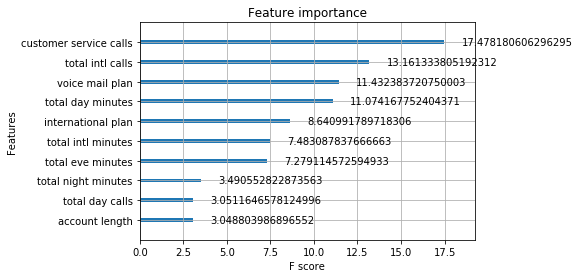

In [48]:
plot_importance(clf,importance_type='gain', max_num_features=10)
pyplot.show()

In the above plot, we've chosen to look at gain. Thank you to Amjad Abu-Rmileh for detailing here: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

Our most important features when it comes to predicting churn:
- Customer service calls
- Total international calls (and charge, based on our heat map!)
- Voice mail plan

Let's check these out in detail.

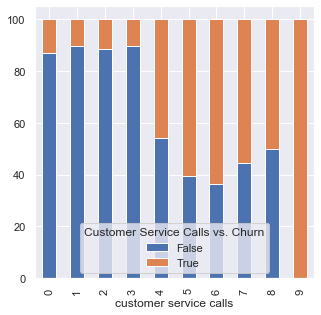

In [100]:
#customer service calls 100% stacked bar

ax= pd.crosstab(df['customer service calls'], df['churn']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(5,5),stacked=True)
plt.legend(loc='lower center', title="Customer Service Calls vs. Churn")

# When we look at customer service calls as a percentage, rather than raw numbers, a trend becomes apparent.
# If customers call in 4 or more times, the churn likelihood jumps.
# This is a great quantitative focus for improvement - eg an alert when customers call in 2 or 3 times.

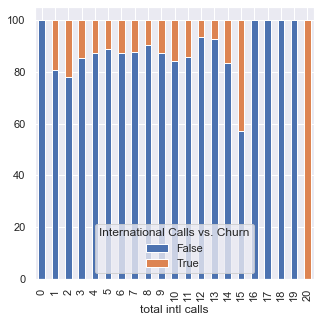

In [103]:
#total international calls scatter plot
ax= pd.crosstab(df['total intl calls'], df['churn']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(5,5),stacked=True)
plt.legend(loc='lower center', title="International Calls vs. Churn")

# We see a similar (but less neat) pattern with international calls. 

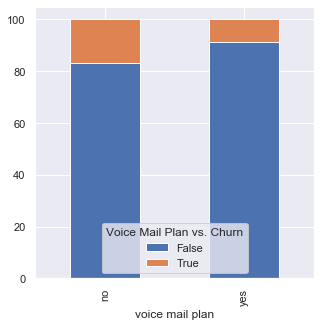

In [104]:
ax= pd.crosstab(df['voice mail plan'], df['churn']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(5,5),stacked=True)
plt.legend(loc='lower center', title="Voice Mail Plan vs. Churn")

# Voice mail plan is interesting as well - it seems that customers WITHOUT a plan are more likely to churn!

In [116]:
VM_False = df["voice mail plan"][df_copy["voice mail plan"] == False]
VM_False_Churn = df[(df["voice mail plan"] == "no") & (df["churn"] == True)]
VM_True_Churn = df[(df["voice mail plan"] == "yes") & (df["churn"] == True)]

print ("VM False Percentage = "+str( (VM_False.shape[0] / df["voice mail plan"].shape[0]) * 100 ))
print ("VM False Churn = "+str( (VM_False_Churn.shape[0] / df["voice mail plan"].shape[0]) * 100 ))
print ("VM True Churn = "+str( (VM_True_Churn.shape[0] / df["voice mail plan"].shape[0]) * 100 ))


# Wow! Customers with voice mail plans only churn 2.4% of the time, compared with a much more "normal"
# 12.1% for customers wihout a voice mail plan.
# That means operationally we can almost ignore the customers with a voice mail plan - unless they fit 
# another criterium for churn!

VM False Percentage = 72.33723372337234
VM False Churn = 12.091209120912092
VM True Churn = 2.4002400240024
